# PySpark Setup

In [1]:
#######################################
###!@0 START INIT ENVIRONMENT
from google.colab import drive
drive.mount('/content/drive')
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
#!wget -q https://mirrors.estointernet.in/apache/spark/spark-3.0.3/spark-3.0.3-bin-hadoop2.7.tgz -P /content/drive/MyDrive # link wrong in blog
!tar xf /content/drive/Shareddrives/DA231-2021-Aug-Public/spark-3.0.3-bin-hadoop2.7.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.3-bin-hadoop2.7"

###!@0 END INIT ENVIRONMENT

#######################################
###!@1 START OF PYSPARK INIT
# Provides findspark.init() to make pyspark importable as a regular library.
# Resource : https://pypi.org/project/findspark/
import findspark
findspark.init()
findspark.find()
from pyspark.sql import SparkSession
spark = SparkSession.builder\
         .master("local")\
         .appName("Colab")\
         .config('spark.ui.port', '4050')\
         .getOrCreate()
spark
# Spark is ready to go within Colab!
###!@1 END OF PYSPARK INIT

Mounted at /content/drive


# Downloading yahoo finance

In [3]:
! pip install yfinance

     |████████████████████████████████| 6.3 MB 5.8 MB/s 
  Attempting uninstall: lxml
    Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


# Code Structure
# 1. Imports and Path definitions
# 2. Sample data download using yahoo finance and trading data plot 
# 3. Trading Data Fetcher
# 4. Function Definitions
# 5. End-to-End Functions in Action
# 6. Evaluations of scaling 

Note : Sample data fetcher takes time to fetch trading data for all the coins / stocks

# 1. Default Imports and Data Path Definition

In [20]:
# other necessary imports
import pandas as pd
import yfinance as yf
import datetime
import requests
import io
import time
import pyspark.sql.functions as F
from pyspark.sql.window import Window
import math
import time

path = '/content/drive/Shareddrives/DA231 Project - Portfolio Recommendation/Datasets/'

#2. Sample data download using yahoo finance and trading data plot

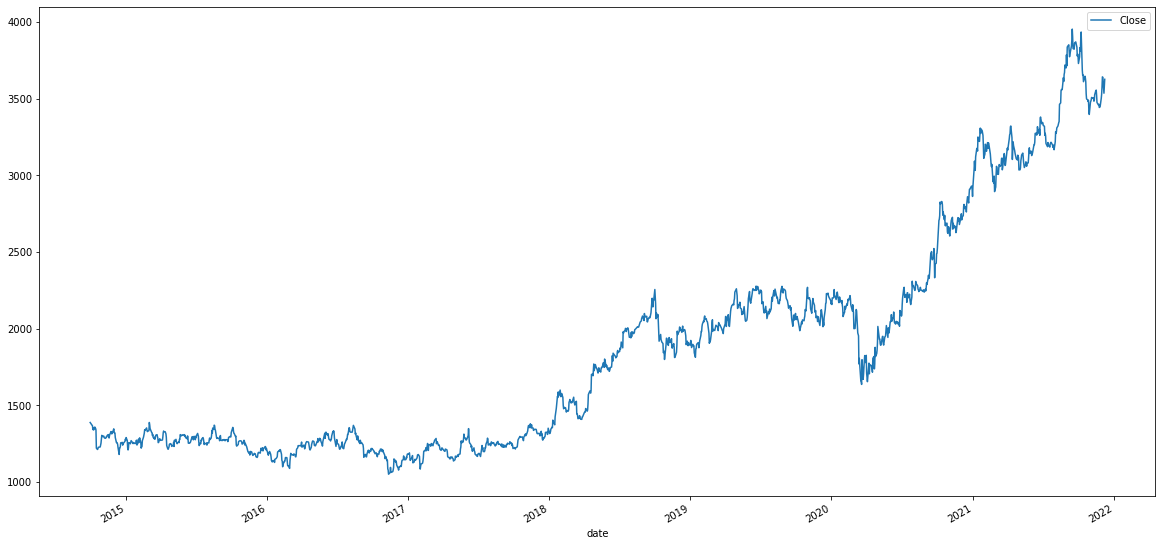

In [22]:
# Get trading data for a scrip name
# TCS trading data 

start = datetime.datetime(2014,10,1)
end = datetime.datetime(2021,12,9)

stock = yf.download('TCS.NS',start=start, end=end, progress=False)
stock['date']= stock.index
stock.plot(x = 'date', y='Close', figsize=(20, 10) )

# 3. Trading Data Fetcher

For fetching trading data of stocks and cryptos

## 3.1 Trading Data Fetcher Cryptos

In [ ]:
# Reading scrip names for different bitcoins (downloaded from web)
# Adding a sting '-USD' at the end of scrip name to fetch coin data in USD


coins_scrip = spark.read.parquet(path+'coins_shortlisted').toPandas()
coins_scrip['ticker'] = coins_scrip['ticker'] + '-USD'
symbols = coins_scrip['ticker'].tolist()

In [ ]:
# ITERATIVELY DONWLOAD COIN DATA OF SEVERAL COMPANIES
# create empty dataframe

start = datetime.datetime(2014,10,1)
end = datetime.datetime(2021,12,8)

coins_final = pd.DataFrame()
# iterate over each symbol
for i in symbols:  
    
    # print the symbol which is being downloaded
    print( str(symbols.index(i)) + str(' : ') + i, sep=',', end=',', flush=True)  
    
    try:
        # download the stock price 
        stock = []
        stock = yf.download(i,start=start, end=end, progress=False)
        
        # append the individual stock prices 
        if len(stock) == 0:
            None
        else:
            stock['Name']=i
            coins_final = coins_final.append(stock,sort=False)
    except Exception:
        None

In [ ]:
# Writing the coin data to a csv

coins_final.to_csv(path+'coins_trading_data_new.csv')

## 3.2 Trading Data Fetcher Stocks

In [71]:
# Reading scrip name for NSE stocks usin trading snapshot file downloaded from NSE website

stock_scrips = pd.read_csv(path+'stocks_base_file.csv')
stock_scrips['scrip'] = stock_scrips['SYMBOL'] +'.NS' 
stock_symbols = stock_scrips['scrip'].tolist()

In [73]:
# ITERATIVELY DONWLOAD STOCK DATA OF SEVERAL COMPANIES
# create empty dataframe

start = datetime.datetime(2021,12,7)
end = datetime.datetime(2021,12,8)

stocks_final = pd.DataFrame()
# iterate over each symbol
for i in stock_symbols:  
    
    # print the symbol which is being downloaded
    print( str(stock_symbols.index(i)) + str(' : ') + i, sep=',', end=',', flush=True)  
    
    try:
        # download the stock price 
        stock = []
        stock = yf.download(i,start=start, end=end, progress=False)
        
        # append the individual stock prices 
        if len(stock) == 0:
            None
        else:
            stock['Name']=i
            stocks_final = stocks_final.append(stock,sort=False)
    except Exception:
        None

In [ ]:
# Writing stock data to csv

stocks_final_new = stocks_final
stocks_final_new['date_time']  =  stocks_final_new.index
stocks_final_new.to_csv(path+"stocks_trading_data_new.csv")

In [ ]:
# Downloading nifty 50 index data

stocks_index = yf.download('^NSEI',start=datetime.datetime(2010,1,1), end=datetime.datetime(2021,12,8), progress=False)
stocks_index['date_time'] = stocks_index.index

stocks_index.to_csv("drive/Shareddrives/DA231 Project - Portfolio Recommendation/Datasets/stocks_index_trading_data.csv")
stocks_index_spark_df = spark.createDataFrame(stocks_index[stocks_index['date_time'] >= '2020-01-01 00:00:00'])

# Run from here after running the imports to send the trading data fetched for portfolio generation

# 4. Function Definitions


## 4.1 Filter Stocks

In [14]:
# Method to filter stocks

from pyspark.sql.functions import col
def selectStocks(marketCapCutOffCount = 750, minDateForTradedVolMean = '2019-12-31', totalListSize = 500, recencyFactor = 4, minDataCountForYear = 200):
  stockDataMcapFile = path+ 'stock-mcap-final.csv'
  stockTradingDataFile = path  + 'stocks_trading_data_new.csv'
  stockMcapData = spark.read.option("header",True).option("inferSchema",True).csv(stockDataMcapFile)
  stockMcap = stockMcapData.where(col('Symbol').isNotNull()).where(col('Company Name').isNotNull()).where(col('Market capitalization').isNotNull())\
                         .withColumn("market-cap", col("Market capitalization").cast('int'))
  stockTradingData = spark.read.option("header",True).option("inferSchema",True).csv(stockTradingDataFile)
  stockTradingDataRecency = stockTradingData.withColumn("Year", F.year("date_time")).groupby("Name", "Year").count()
  stockTradingData = stockTradingData.select("Name", "Volume", "date_time").where(col("date_time") > minDateForTradedVolMean)

  mCapDataWithRecency = stockMcap.join(stockTradingDataRecency, stockMcap.Symbol == F.expr("substring(Name, 0, length(Name)-3)")).where(col("Year") > 2021 - recencyFactor)\
                  .where(col("count") > minDataCountForYear ).select("Name", "Year", "Count", "market-cap")\
                  .groupby("Name", "market-cap").count().where(col("count") == recencyFactor)
  top750StocksByMarketCap = mCapDataWithRecency.withColumn("rank", F.rank().over(Window.orderBy(F.desc("market-cap"))))\
                                   .where(col("rank") <= marketCapCutOffCount)

  volTradedMean = stockTradingData.groupby("Name").avg("Volume")\
                         .withColumnRenamed("avg(Volume)", "traded_vol_mean").withColumnRenamed("Name", "Symbol")
  # Ratio of avg traded volume with market capitalization and select top 500 for analysis
  volToMcap = volTradedMean.join(top750StocksByMarketCap, volTradedMean.Symbol == top750StocksByMarketCap.Name)\
                         .select("Name", "market-cap", "traded_vol_mean")\
                         .withColumn("vol/mCap", col("traded_vol_mean")/F.sqrt(col("market-cap")))\
                         .withColumn("rank", F.rank().over(Window.orderBy(F.desc("vol/mCap"))))\
                         .where(col("rank") <= totalListSize)\
                         .select("Name", "vol/mCap", "rank")

  tickerStrings = volToMcap.select("Name").collect()
  stockList = []
  for ticker in tickerStrings:
    stockList.append(ticker[0])

  return stockList

## 4.2 Filter Cryptos

In [82]:
def cryptoCurrencyShortlist(RawDataDf, recencyCutoff = 30):
  # Remove any blanks found on crypto_name column
  RawDF = spark.read.csv(path+"crypto_tradinds.csv")
  cryptoCleaned = RawDataDf.withColumn("trade_date",RawDataDf["trade_date"].cast("Date")) \
  .where( (col("crypto_name").isNotNull()) & (col("crypto_name")!=''))

  # Compute the max date, recency cutoff date and marketcap cutoff date relative to maximum date
  maxDatedf=cryptoCleaned.select(F.max("trade_date").alias("maxDate"),
                                  F.date_add(F.max("trade_date"), - recencyCutoff).alias('recency_cutoff_date')                                  
                                  )

  # Apply recency filter
  cryptoRecent = cryptoCleaned.where(col("trade_date")>maxDatedf.first()["recency_cutoff_date"]).select("ticker","crypto_name")

  # Remove cases where multiple crypto_name  has the same ticker
  cryptos = cryptoRecent.withColumn('cnts', F.count('Name').over(Window.partitionBy('ticker'))) \
  .filter("cnts = 1") \
  .select(['Name', 'ticker'])

  return cryptos

## 4.3 Find Portfolio

In [8]:
# Method to find portfolio
# Arguments 
# trading_df = daily trading data of different scips
# index_df = daily trading data of the benchmarking index of the market
# price_column, price_column_index = closing price column for scrip / index
# scrip_column = scrip identifier column
# amount = basic unit of investment
# risk_free_return = avg return for 1 year FD (minimum risk)
# num_scrips = number of scrips to be in the portfolio
# exclude_yr = year that needs to be excluded 
## asset_type = 'S for stocks else coins

def get_portfolio(trading_df, index_df, price_column, price_column_index, scrip_column, amount=500000, risk_free_retun = 0.04, num_scrips = 20, exclude_yr = 2020, asset_type = 'S') :  
  index_edited = index_df \
  .withColumn('dt', F.expr("date(date_time)")) \
  .withColumn('index_price',F.col(price_column)) \
  .select("dt",'index_price')

  if(asset_type == 'S'):
    amount_threshold = 10
    denominator = num_scrips
    latest_price = trading_df.withColumn('dt', F.expr("date(date_time)")).filter("dt = '2021-12-06'") \
    .select(scrip_column, price_column) \
    .filter("{} <= {}/{} and {} > {}".format(price_column, amount, denominator, price_column,amount_threshold))

  else :
    latest_price = trading_df.withColumn('dt', F.expr("date(date_time)")).filter("dt = '2021-12-06'") \
    .select(scrip_column, price_column)



  trading_df_edited = trading_df.withColumn('dt', F.expr("date(date_time)")) \
  .withColumn('price',F.col(price_column)) \
  .join(index_edited, ['dt'], 'inner') \
  .join(latest_price.select(scrip_column), [scrip_column], 'inner')

## calculate returns wrt to same day of week, week of the year previous year
  yearly_returns = trading_df_edited.withColumn('year', F.expr("year(dt)")) \
  .withColumn('week_num', F.expr("weekofyear(dt)")) \
  .withColumn('dayofweek', F.expr("dayofweek(dt)")) \
  .withColumn('closing_price_sd_ly', F.lag('price').over(Window.partitionBy(scrip_column,'week_num','dayofweek').orderBy('year'))) \
  .withColumn('return', F.expr("price/closing_price_sd_ly - 1")) \
  .withColumn('closing_price_sd_ly_index', F.lag('index_price').over(Window.partitionBy(scrip_column,'week_num','dayofweek').orderBy('year'))) \
  .withColumn('index_return', F.expr("index_price/closing_price_sd_ly_index - 1"))

## calculate risk = stddev
  metrics = yearly_returns \
  .filter("year >= {}".format(exclude_yr)) \
  .groupby(scrip_column) \
  .agg(F.stddev('return').alias('stdev_return'), F.avg('return').alias('avg_return'), F.count('dt').alias('datapoints'), 
       F.avg('index_return').alias('avg_index_return')) \
  
## calculate beta, sharp ratio
  aggregated = yearly_returns.join(metrics, [scrip_column], 'inner') \
  .groupBy(scrip_column).agg(F.avg('stdev_return').alias('risk_scrip'), 
                             F.avg(F.expr("(return-avg_return)*(index_return - avg_index_return)")).alias('covariance'), 
                             F.avg(F.expr("(index_return - avg_index_return)*(index_return - avg_index_return)")).alias('variance'),
                             F.avg('avg_return').alias('avg_return'),
                             F.avg("avg_index_return").alias("avg_index_return")) \
                             .select(scrip_column, F.expr("covariance/variance").alias('beta'), 
                                     F.expr("(avg_return - {})/risk_scrip".format(risk_free_retun)).alias('sharpe_ratio'), 'risk_scrip','covariance')
                             
  
  bucketed = aggregated.withColumn('risk_perc', F.ntile(5).over(Window.partitionBy().orderBy('risk_scrip'))) \
  .withColumn('beta_perc', F.ntile(3).over(Window.partitionBy('risk_perc').orderBy('beta')))

 ## find portfolio => for each risk profile and hedging preferenc find the assets that would go inside the portfolio 
  dist_mapping = {0: [0.5,0.3,0.2], 1:[1/3,1/3,1/3], 2: [0.2,0.3,0.5]}
  stock_counts = {}
  hedges = {}
  for i in range(3):
    stock_counts[i] = [math.ceil(x*num_scrips) for x in dist_mapping[i]]  
    hedges[i] = bucketed.withColumn('stock_priority', F.row_number().over(Window.partitionBy('risk_perc','beta_perc').orderBy(F.desc('sharpe_ratio')))) \
    .filter("(beta_perc = 1 and stock_priority <= {}) or (beta_perc = 2 and stock_priority <= {}) or (beta_perc = 3 and stock_priority <= {})"
    .format(stock_counts[i][0],stock_counts[i][1], stock_counts[i][2])) \
    .withColumn('hedge_category', F.lit(i))
  
  selections = hedges[0].union(hedges[1].union(hedges[2]))

  if(asset_type == 'S') :
    hedge_cat_selections = selections \
    .join(latest_price.select(scrip_column, F.col(price_column).alias("latest_price")), [scrip_column], 'inner') \
    .withColumn('qty', F.expr("round({}/({}*latest_price))".format(amount,num_scrips)))
  
  else :
    hedge_cat_selections = selections \
    .join(latest_price.select(scrip_column, F.col(price_column).alias("latest_price")), [scrip_column], 'inner') \
    .withColumn('qty', F.expr("({}/({}*latest_price))".format(amount,num_scrips)))

## Map scrip to asset name
  stock_mapping = spark.read.csv(path+ 'stock_mapping.csv', header = True)
  coin_mapping = spark.read.csv(path+ 'coin_mapping.csv', header = True)

  mapping = stock_mapping.union(coin_mapping)

  output = hedge_cat_selections.join(mapping, [scrip_column], 'inner')


  return output                                    

# 5. End to end functions in action

## 5.1 Generate Portfolio for stocks

### 5.1.1 Filter Stocks 

In [15]:
scrips = selectStocks(marketCapCutOffCount = 1500, minDateForTradedVolMean = '2019-12-31', totalListSize = 1000, recencyFactor = 4, minDataCountForYear = 200)
stocks_to_be_evaluated = spark.createDataFrame(pd.DataFrame(data=scrips, columns = ['Name']))

In [18]:
scrips[:10]

['IDEA.NS',
 'RCOM.NS',
 'RPOWER.NS',
 'YESBANK.NS',
 'JPPOWER.NS',
 'SITINET.NS',
 'SOUTHBANK.NS',
 'GTLINFRA.NS',
 'VIKASECO.NS',
 'BHEL.NS']

### 5.1.2 Send the filtered data for portfolio generation

In [16]:
# Reading stock data
# Filtering 2 years of stock data

stocks_final_new = pd.read_csv(path+'stocks_trading_data_new.csv')
stocks_spark_df = spark.createDataFrame(stocks_final_new[stocks_final_new['date_time'] >= '2019-01-01 00:00:00'])


# Reading stock index data
# Filtering 2 years of stock index data

stocks_index = pd.read_csv(path+'stocks_index_trading_data.csv')
stocks_index_spark_df = spark.createDataFrame(stocks_index[stocks_index['date_time'] >= '2020-01-01 00:00:00'])

input_df = stocks_spark_df.join(stocks_to_be_evaluated, ['Name'], 'inner')

stocks_portfolio = get_portfolio(input_df, stocks_index_spark_df, 'Close', 'Close','Name', 50000,0.04,20, 2020, 'S')

stocks_portfolio.show()
#uncomment the below lne to write the results to a file
#stocks_portfolio.toPandas().to_csv(path+'portfolio_recommendations.csv', index = False)

+-------------+------------------+------------------+-------------------+--------------------+---------+---------+--------------+--------------+------------------+----+--------------------+----------+
|         Name|              beta|      sharpe_ratio|         risk_scrip|          covariance|risk_perc|beta_perc|stock_priority|hedge_category|      latest_price| qty|          Asset_Name|Asset_Type|
+-------------+------------------+------------------+-------------------+--------------------+---------+---------+--------------+--------------+------------------+----+--------------------+----------+
|  JUBLINDS.NS| 2.702649952656058| 2.305937458053214| 0.8323905502422977| 0.06453878184381026|        5|        1|             7|             0|            514.25| 5.0|Jubilant Industri...|     stock|
|  JUBLINDS.NS| 2.702649952656058| 2.305937458053214| 0.8323905502422977| 0.06453878184381026|        5|        1|             7|             1|            514.25| 5.0|Jubilant Industri...|     st

In [21]:
stocks_portfolio.filter("risk_perc = 1 and hedge_category = 1").select('Asset_Type', 'Asset_Name', 'Name').show(20,False)

+----------+---------------------------------------------+-------------+
|Asset_Type|Asset_Name                                   |Name         |
+----------+---------------------------------------------+-------------+
|stock     |Aarti Industries Limited                     |AARTIIND.NS  |
|stock     |Crompton Greaves Consumer Electricals Limited|CROMPTON.NS  |
|stock     |Balkrishna Industries Limited                |BALKRISIND.NS|
|stock     |Ravi Kumar Distilleries Limited              |RKDL.NS      |
|stock     |Havells India Limited                        |HAVELLS.NS   |
|stock     |The India Cements Limited                    |INDIACEM.NS  |
|stock     |Marico Limited                               |MARICO.NS    |
|stock     |Infosys Limited                              |INFY.NS      |
|stock     |Manaksia Limited                             |MANAKSIA.NS  |
|stock     |Navkar Corporation Limited                   |NAVKARCORP.NS|
|stock     |Caplin Point Laboratories Limited      

## 5.2 Generate Portfolio for Crypto

In [48]:
coins_index = spark.read.csv(path+'updated_bench_crypto_data.csv', header = True) \
.withColumn('Close', F.expr("Close*75")) \
.withColumnRenamed('Date', 'date_time')

coins_trading = spark.read.csv(path+ 'coins_trading_data_new.csv', header = True) \
.withColumn('Close', F.expr("Close*75")) \
.withColumnRenamed('Date', 'date_time')

coins_portfolio = get_portfolio(coins_trading, coins_index, 'Close', 'Close','Name', 50000,0.04,20, 2019, 'C')
coins_portfolio.toPandas().to_csv(path+'coins_portfolio_recommendations.csv', index = False)

# 6. Evaluations of scaling

## 6.1 
#### Time taken for generating portfolio vs number of years of trading data
#### Colab resources crash, so ran it on a separate databricks cluster for reporting 

In [ ]:
times = {}

stocks_final_new = pd.read_csv(path+'stocks_trading_data_new.csv')
stocks_index = pd.read_csv(path+'stocks_index_trading_data.csv')

for i in range(5):
  print("iteration : ",i)
  start_time = time.time()
  x = 2020-i

  input_stock = spark.createDataFrame(stocks_final_new[stocks_final_new['Date']>='{}-01-01'.format(x)])
  input_index = spark.createDataFrame(stocks_index[stocks_index['date_time'] >= '{}-01-01 00:00:00'.format(x)])

  df = get_portfolio(input_stock, input_index, 'Close', 'Close','Name', 50000,0.04,20, x)
  print("Count rows : ", df.count())
  end_time = time.time()
  run_time = end_time - start_time
  print("run time : ", run_time)
  times[i]=run_time 

## 6.2
#### Time taken using pyspark dataframes vs pandas dataframes for calculating stock risk for different data sizes

#### Replicated this evaluation on a databricks machine

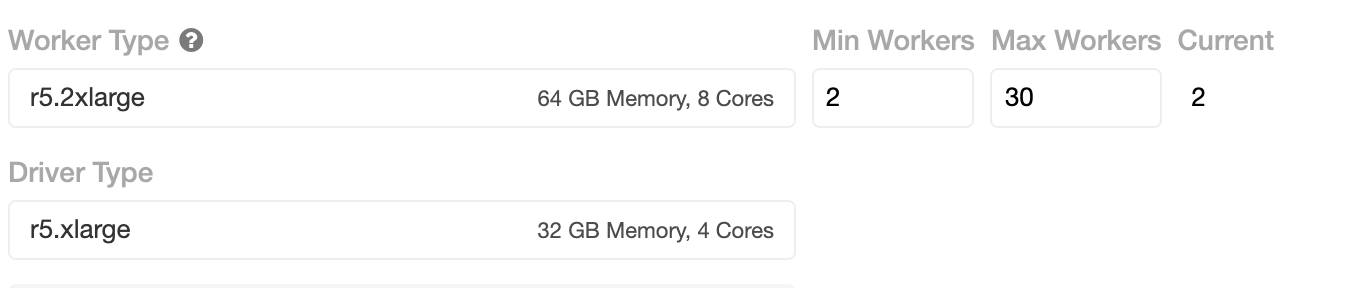

In [51]:
def getstddevspark(df):
  stddev = df.groupby('Name').agg(F.stddev('return'))
  return stddev

def getstddevpandas(df):
  stddev = df.groupby('Name').agg({'return': 'std'})
  return stddev

In [50]:
df = pd.read_csv(path+'yearly_returns.csv')

In [78]:
spark_time = {}
pandas_time = {}
for i in range(10000,500000,10000):
  print("iteration : ", i)
  df_sampled = df.sample(i)
  df_spark= spark.createDataFrame(df_sampled)
  spark_start = time.time()
  spark_stddev = getstddevspark(df_spark)
  spark_stddev.count()
  spark_end = time.time()
  spark_time[i] = spark_end -spark_start
  print("spark_time : ", spark_time[i])
  pandas_start = time.time()
  pandas_stddev = getstddevpandas(df_sampled)
  len(pandas_stddev)
  pandas_end = time.time()
  pandas_time[i] = pandas_end - pandas_start
  print("pandas_time : ", pandas_time[i])